In [14]:
from typing import List, Tuple, Iterable
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy
import qiskit
from qiskit import opflow
from qiskit.opflow.primitive_ops import PauliSumOp

In [2]:
def ising_hamiltonian(pauli_list: List[Tuple[str, float]]) -> PauliSumOp:
    return PauliSumOp.from_list(pauli_list)

def get_thermal_state(H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
    H = H.mul(-1 * beta) # returns -beta*H
    exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
    partition_function = np.trace(exp_H)
    return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

-1.0 * ZZ
- 1.0 * IZ
+ 1.0 * ZI


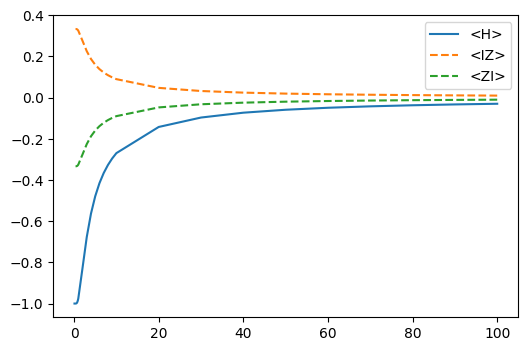

In [3]:
temp_range = list(np.arange(100, 1, -10)) + list(np.arange(9,0,-1)) + list(np.arange(0.9, 0, -0.1))

pauli_list = [('ZZ', -1), ('IZ', -1), ('ZI', 1)]
H = ising_hamiltonian(pauli_list)
print(H)
energy = []
avg_mag = []
for t in temp_range:
    beta = 1/t    
    rho = get_thermal_state(H, beta)
    energy.append(rho.expectation_value(H).real)
    spin0 = rho.expectation_value(PauliSumOp.from_list([('IZ', 1)])).real
    spin1 = rho.expectation_value(PauliSumOp.from_list([('ZI', 1)])).real
    avg_mag.append((spin0, spin1))
    
fig, ax = plt.subplots(dpi=100)
ax.plot(temp_range, energy, label='<H>')
ax.plot(temp_range, [m[0] for m in avg_mag], ls='--', label='<IZ>')
ax.plot(temp_range, [m[1] for m in avg_mag], ls='--', label='<ZI>')
ax.legend()

In [36]:
class QuantumBoltzmannMachine:
    def __init__(self, graph: nx.Graph, visible_nodes: List[int], hidden_nodes: List[int]) -> None:
        self.graph = graph
        self.num_units = len(list(self.graph.nodes))
        
        # Check valid input
        for i, j in zip(sorted(visible_nodes + hidden_nodes), range(self.num_units)):
            if i != j:
                raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        if len(visible_nodes) + len(hidden_nodes) != self.num_units:
            raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        for v1, v2 in self.graph.edges:
            if (v1 in hidden_nodes and v2 in hidden_nodes) or (v1 in visible_nodes and v2 in visible_nodes):
                raise ValueError("Only Restricted Boltzmann Machines are currently supported")
        
        self.visible_nodes = visible_nodes
        self.hidden_nodes = hidden_nodes
        self.visible_node_map = {node: index for index, node in enumerate(self.visible_nodes)}
        
        # Parameter initialization
        self.single_params = np.array([np.random.uniform(low=-1.0, high=1.0) for _ in range(self.num_units)])
        self.double_params = {edge: np.random.uniform(low=-1.0, high=1.0) for edge in self.graph.edges}

            
    def eval_energy(self, state: Tuple[int]) -> float:
        energy_sum = 0.0
        for i in range(self.num_units):
            energy_sum += -1 * (self.single_params[i] * state[i])
        
        for edge in self.graph.edges:
            energy_sum += -1 * (self.double_params[edge] * state[edge[0]] * state[edge[1]])
        
        return energy_sum
    
    
    def _gen_states(self, n: int) -> List[Tuple[int]]:
        bitstrings = []
        for i in range(int(2**n)):
            bitstrings.append(f'{i:0{n}b}')
            
        states = []
        for bitstr in bitstrings:
            state = [1 if b == '0' else -1 for b in bitstr]
            states.append(tuple(state))
        
        return states
    
    
    def _partition_function(self) -> float:
        states = self._gen_states(self.num_units)
        Z = 0
        for state in states:
            energy = self.eval_energy(state)
            Z += np.exp(-1 * energy)
        
        return Z
    
    
    def _get_combined_state(self, visible_state: Tuple[int], hidden_state: Tuple[int]) -> Tuple[int]:
        state = np.zeros(self.num_units, dtype=int)
        
        for i, s in enumerate(visible_state):
            state[self.visible_nodes[i]] = s
        
        for i, s in enumerate(hidden_state):
            state[self.hidden_nodes[i]] = s
        
        if 0 in state:
            raise ValueError(f'The combined state {state} contains an unassigned node!')
            
        return tuple(state)
    
    
    def get_distribution(self) -> dict:
        visible_states = self._gen_states(len(self.visible_nodes))
        hidden_states = self._gen_states(len(self.hidden_nodes))
        
        Z = self._partition_function()
        
        probability_dist = {}
        
        for visible_state in visible_states:
            numerator = 0
            for hidden_state in hidden_states:
                numerator += np.exp(-1 * self.eval_energy(self._get_combined_state(visible_state, hidden_state)))
            
            probability_dist[visible_state] = numerator / Z
        
        return probability_dist
    
    
    def log_likelihood(self, data_dist: dict, model_dist: dict) -> float:
        visible_states = self._gen_states(len(self.visible_nodes))
        
        log_likelihood = 0.0
        for visible_state in visible_states:
            p_v_data = data_dist.get(visible_state, 0)
            p_v_model = model_dist.get(visible_state, 0)
            if p_v_model > 0:
                log_likelihood -= p_v_data * np.log2(p_v_model)
        
        return log_likelihood
    
    
    def plot_dist(self, dist: dict, data_dist: dict = None) -> None:
        fig, ax = plt.subplots(figsize=[15,5])
        xvals, yvals = [], []
        for key, val in dist.items():
            bitstring = ''.join(['1' if b == 1 else '0' for b in key])
            xvals.append(int(bitstring, 2))
            yvals.append(val)
            
        width = 0.4
        
        ax.bar(xvals, yvals, color='palegreen', label=r'$P^{model}_v$', align='edge', width=width)
        
        if data_dist is not None:
            data_xvals, data_yvals = [], []
            for key, val in data_dist.items():
                bitstring = ''.join(['1' if b == 1 else '0' for b in key])
                data_xvals.append(int(bitstring, 2))
                data_yvals.append(val)
            ax.bar(data_xvals, data_yvals, color='lightsalmon', label=r'$P^{data}_v$', align='edge', width=-width)
            
        plt.grid(alpha=.4, linestyle='--')
        plt.legend(fontsize=14)
        plt.xlabel(r'Visible state', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.show()
        plt.close()
    
    
    def get_hamiltonian(self, clamped: bool = False) -> PauliSumOp:
        pauli_list = []
        
        # single terms
        for node, param in enumerate(self.single_params):
            if clamped and node in self.visible_nodes:
                continue
            pauli = ['I'] * self.num_units
            pauli[node] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        # double terms
        for edge in self.graph.edges():
            if clamped and edge[0] in self.visible_nodes and edge[1] in self.visible_nodes:
                continue
            param = self.double_params[edge]
            pauli = ['I'] * self.num_units
            pauli[edge[0]] = 'Z'
            pauli[edge[1]] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        return PauliSumOp.from_list(pauli_list)


    def get_thermal_state(self, H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
        H = H.mul(-1 * beta) # returns -beta*H
        exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
        partition_function = np.trace(exp_H)
        return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)


    def compute_clamped_expectation(self, i: int, visible_state: Tuple[int]) -> float:
        # Eq 36 of Amin et al.
        b_i_eff = self.single_params[i] + sum([self.double_params.get(tuple(sorted((i,j))), 0) * v_j for j, v_j in enumerate(visible_state)])
        D_i = np.sqrt(b_i_eff**2) # modify this when updating the Hamiltonian to actually be quantum
        return (b_i_eff / D_i) * np.tanh(D_i)
    
    
    def exact_optimization(self, data_dist: dict, step_size: float = 0.1, cutoff: float = 1e-3,
                           max_epoch: int = 100, verbose: int = 0, beta: float = 10.0) -> None:
        cur_epoch = 1
        progress = 100
        cur_log_likelihood = self.log_likelihood(data_dist, self.get_distribution())
        while progress > cutoff and cur_epoch <= max_epoch:
            # Get clamped and unclamped Hamiltonians
            unclamped_hamiltonian = self.get_hamiltonian(clamped=False)
            #clamped_hamiltonian   = self.get_hamiltonian(clamped=True)
            
            # Get their respective low-temperature thermal states
            unclamped_rho = self.get_thermal_state(unclamped_hamiltonian, beta)
            #clamped_rho = self.get_thermal_state(clamped_hamiltonian, beta)
            
            # Update parameters, Theta(n) -> Theta(n+1)
            new_single_params = copy.copy(self.single_params)
            new_double_params = copy.copy(self.double_params)
            
            # First, update the single parameters 
            single_param_deltas = []
            for i in range(len(self.single_params)):
                # positive phase, <z_i>_v -> clamped
                positive_phase = 0
                for visible_state, p_v_data in data_dist.items():
                    if i in self.visible_nodes:
                        expectation = visible_state[self.visible_node_map[i]]
                    else:
                        expectation = self.compute_clamped_expectation(i, visible_state)
                    positive_phase += p_v_data * expectation
                
                # negative phase, <z_i> -> unclamped
                paulistr = ['I'] * self.num_units
                paulistr[i] = 'Z'
                paulistr = ''.join(reversed(paulistr))
                negative_phase = unclamped_rho.expectation_value(PauliSumOp.from_list([(paulistr, 1)])).real
                
                new_single_params[i] += step_size * (positive_phase - negative_phase)
                
            # Second, update the double parameters
            double_param_deltas = {}
            for edge in self.double_params.keys():
                # positive phase, <z_i*z_j>_v -> clamped
                positive_phase = 0
                for visible_state, p_v_data in data_dist.items():
                    if edge[0] in self.visible_nodes:
                        expectation = visible_state[self.visible_node_map[edge[0]]] * self.compute_clamped_expectation(edge[1], visible_state)
                    elif edge[1] in self.visible_nodes:
                        expectation = visible_state[self.visible_node_map[edge[1]]] * self.compute_clamped_expectation(edge[0], visible_state)
                    else:
                        raise Exception('Something went wrong, expected an RBM graph structure')
                    positive_phase += p_v_data * expectation
                
                # negative phase, <z_i*z_j> -> unclamped
                paulistr = ['I'] * self.num_units
                paulistr[edge[0]] = 'Z'
                paulistr[edge[1]] = 'Z'
                paulistr = ''.join(reversed(paulistr))
                negative_phase = unclamped_rho.expectation_value(PauliSumOp.from_list([(paulistr, 1)])).real
                
                new_double_params[edge] += step_size * (positive_phase - negative_phase)
                
            # Perform the update
            self.single_params = new_single_params
            self.double_params = new_double_params
            
            new_log_likelihood = self.log_likelihood(data_dist, self.get_distribution())
            progress = abs(new_log_likelihood - cur_log_likelihood)
            
            if verbose > 0 and (cur_epoch-1) % 10 == 0:
                print(f'Finished epoch {cur_epoch}:')
                print(f'\t|L_i - L_i+1| = |{cur_log_likelihood:.5f} - {new_log_likelihood:.5f}| = {progress:.5f}')
            
            cur_log_likelihood = new_log_likelihood
            
            cur_epoch += 1

[0, 1] [2, 3]
[0.86608407 0.76431109 0.31989311 0.38423041]
{(0, 2): -0.9540998367859432, (0, 3): 0.15100969769363615, (2, 1): -0.14554312147982507, (3, 1): -0.7223652403874694}
-0.3198931111085581 * IZII
- 0.3842304051739629 * ZIII
+ 0.9540998367859432 * IZIZ
- 0.15100969769363615 * ZIIZ
+ 0.14554312147982507 * IZZI
+ 0.7223652403874694 * ZIZI


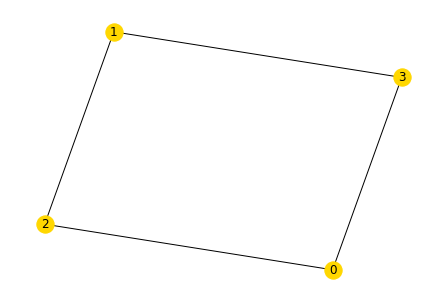

In [44]:
G = nx.Graph()
G.add_edges_from([(0,2), (0,3),
                  (1,2), (1,3)])
nx.draw_spring(G, with_labels=True, node_color='gold')

visible = [0,1]
hidden = [2,3]
bm = QuantumBoltzmannMachine(G, visible, hidden)
print(bm.visible_nodes, bm.hidden_nodes)
print(bm.single_params)
print(bm.double_params)
print(bm.get_hamiltonian(clamped=True))

1.0000000000000002
Log likelihood: L(data, model) = 2.831


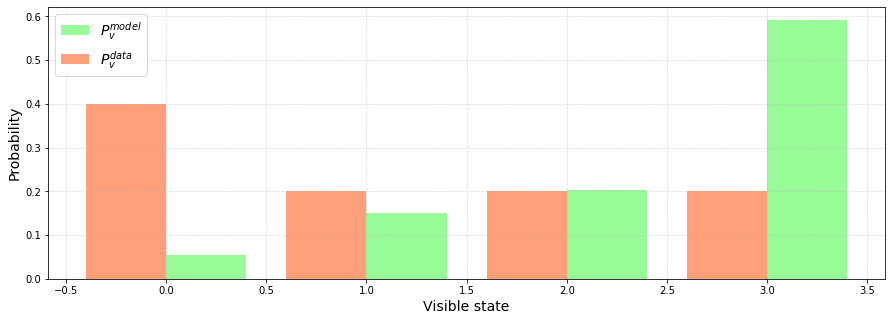

In [45]:
data_dist = {(-1, -1): 0.40, (-1, 1): 0.2, (1, -1): 0.2, (1, 1): 0.2}

model_dist = bm.get_distribution()
print(sum(model_dist.values()))
llh = bm.log_likelihood(data_dist, model_dist)
print(f'Log likelihood: L(data, model) = {llh:.3f}')
bm.plot_dist(model_dist, data_dist=data_dist)

Finished epoch 1:
	|L_i - L_i+1| = |2.83077 - 2.66847| = 0.16230
Finished epoch 11:
	|L_i - L_i+1| = |2.19484 - 2.19842| = 0.00358
Finished epoch 21:
	|L_i - L_i+1| = |2.20720 - 2.20600| = 0.00120
Finished epoch 31:
	|L_i - L_i+1| = |2.18367 - 2.17977| = 0.00391
Finished epoch 41:
	|L_i - L_i+1| = |2.13286 - 2.12700| = 0.00586
Finished epoch 51:
	|L_i - L_i+1| = |2.11429 - 2.11428| = 0.00001
Finished epoch 61:
	|L_i - L_i+1| = |2.11138 - 2.11099| = 0.00039
Finished epoch 71:
	|L_i - L_i+1| = |2.10702 - 2.10652| = 0.00050
Finished epoch 81:
	|L_i - L_i+1| = |2.10123 - 2.10055| = 0.00069
Finished epoch 91:
	|L_i - L_i+1| = |2.09311 - 2.09212| = 0.00099

Final Distribution:



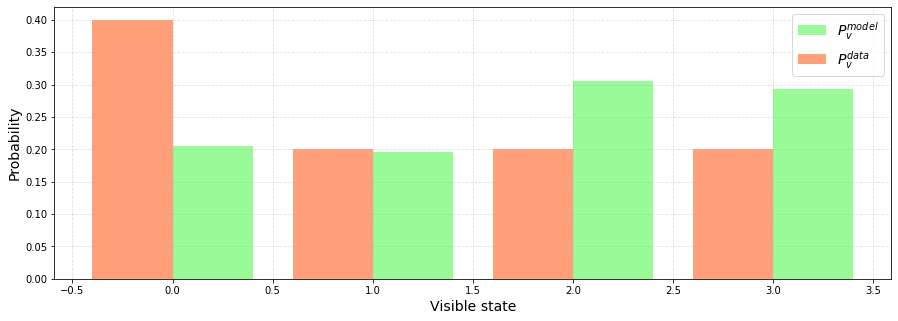

In [46]:
step_size = 0.05
cutoff = 1e-5
max_epoch = 100
bm.exact_optimization(data_dist, step_size=step_size, cutoff=cutoff, max_epoch=max_epoch, verbose=1)
print('\nFinal Distribution:\n')
bm.plot_dist(bm.get_distribution(), data_dist=data_dist)